In [2]:
## Working Notes for http://andrewwalker.github.io/statefultransitions/post/snakes-and-ladders/

# Snakes and Ladders

One of the simplest non-trivial examples of something interesting to do with Markov chains (that's pretty easy to visualise and understand) is working out how many moves (on average) it takes to complete a game of snakes and ladders? This selection of an example is somewhat intentional because it's the same example as the wikipedia entry for [absorbing Markov chains](http://en.wikipedia.org/wiki/Absorbing_Markov_chain), and because it's just hard enough to actually justify solving the problem properly.

A full description of absorbing Markov chains is available on wikipedia, which is a near verbatim transcription from Kemeny and Snell's book (also available online). In short, a (Discrete Time, Finite State) Markov chain is a system that describes the evolution of probability of going from one state to another in an instantaneous transition. Transitions between states are modelled using a stochastic matrix (a matrix where the rows must sum to one).

The wikipedia article on [snakes and ladders](http://en.wikipedia.org/wiki/Snakes_and_Ladders) quotes the solution as 39.6, for the Milton Bradley version of Chutes and Ladders. That's a useful baseline for comparison, because the board layout is easy to find online. It's also worth noting that the page for [absorbing Markov chains](http://en.wikipedia.org/wiki/Absorbing_Markov_chain) quotes the solution as 39.2.

Each of the states in the chain represents a location on the board, and we'll have one extra state (state 0) that represents the initial state off the board. That means we can conveniently number those state 0 - 100 (inclusive), where 0 is the initial state off the board, and 100 is the terminal state.

Ignoring (initially) the chutes and ladders, a transition from a state results in you advancing by the number of squares on a six sided dice.  From any state $x$, you can reach states $x+1, x+2, ..., x+6$, unless such a transition would take you off the board (beyond state 100), where the transition is invalid (which means you stay where you are). The probability of each of these transitions is 1/6, except for the edge case where the move is invalid - in those cases a small adjustment is needed to keep the player in that states.

In [3]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (12, 8)
import numpy as np
from numpy.testing import *
import networkx as nx

In [4]:
def snakes_and_ladders_matrix():
    n = 101
    A = np.zeros((n, n))
    for i in xrange(6):
        A += np.diag(np.ones(n-1-i),i+1)

    # work out the cells that are reachable for every initial cell 
    b = np.sum(A, axis=1)

    # update the transition matrix to have a self-edge for every missing edge 
    A += np.diag(6 - b)

    # normalize
    A /= 6.
    
    return A

A = snakes_and_ladders_matrix()

Q. What is a valid transition matrix?

A. A (right stochastic) transition matrix occurs when the rows of the matrix sum to one.

In [5]:
assert_allclose( 1, np.sum(A, axis=1) )

Q. So for the game with no snakes or ladders, how many moves on average does it take to finish?

A. Easy.

The equation for mean number of steps (from Kemeny and Snell) can be written in terms of the fundamental matrix $N$ and the identity matrix $I$:

$$
N = (I-Q)^{-1}
$$

The equation is then

$$
t = N \mathbf{1}
$$

Where $\mathbf{1}$ is the column vector of ones

<br />

Q. So what's the answer?

A. That isn't how you solve a linear equation.

Solutions to equations on a computer are (solving for $x$) of the form

$$
A x = b
$$

But our unknown is on the wrong side of the equation. Somewhat conveniently, multiplying through by $I-Q$  gives:

$$
(I-Q) t = \mathbf{1}
$$

In [6]:
Q = A[:-1,:-1]
I = np.identity(Q.shape[0])
o = np.ones((Q.shape[0],1))
result = np.linalg.solve(I-Q, o)
print 'turns without snakes and ladders', result[0, 0]

turns without snakes and ladders 33.3333333333


Q. Does that look right?

A. It's pretty close to the wikipedia answer - so we'll assume yes, it is

<br />


Q. So how do you consider the snakes and ladders?

A. Update the transition matrix

In [7]:
ladders = np.array([
    [1, 38],  [4, 14],  [9, 31],  [21,42],
    [28,84],  [36,44],  [51,67],  [71,91],
    [80,100]
]) 

snakes = np.array([
    [98, 78],  [95, 75],  [93, 73],  [87, 24],
    [64, 60],  [62, 19],  [56, 53],  [49, 11],
    [48, 26],  [16, 6],
]) 

def snakes_and_ladders_matrix():
    n = 101
    A = np.zeros((n, n))
    for i in xrange(6):
        A += np.diag(np.ones(n-1-i),i+1)

    # work out the cells that are reachable for every initial cell 
    b = np.sum(A, axis=1)

    # update the transition matrix to have a self-edge for every missing edge 
    A += np.diag(6 - b)

    edges = np.vstack([ladders, snakes])

    for src, dst in edges:
        b = A[:, src].copy()
        A[:, dst] += b
        A[:, src] = 0
    
    A /= 6.
    return A


A = snakes_and_ladders_matrix()
assert_allclose( 1, np.sum(A, axis=1) )

In [8]:
Q = A[:-1,:-1]
I = np.identity(Q.shape[0])
o = np.ones((Q.shape[0],1))
result = np.linalg.solve(I-Q, o)
print 'mean turns to complete', result[0, 0]

mean turns to complete 39.5983656402


Q. Can you visualise the chain?

A. It's ugly, but it might help

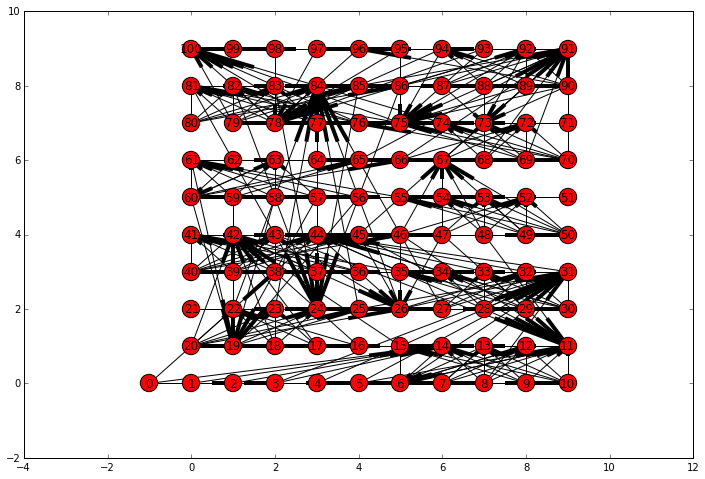

In [9]:
A = snakes_and_ladders_matrix()
G = nx.DiGraph(A)

d = {
    0 : (-1, 0)
}
for i in xrange(100):
    y = i / 10
    x = i % 10
    if y % 2 == 1:
        x = 9-x
    d[i+1] = (x, y)
    
nx.draw_networkx(G, pos = d)

# Sparse Snakes and Ladders

Q. What problems does the last solution have?

A. It's not that efficient

The problem is that the matrix produced takes O($n^2$) storage space, but we're only using about $6n$ states - that is, a no state can reach more than 6 other states. This comes directly from the rules of game - in each turn there are only six possible outcomes. 

In a graph theoretic sense (if we considered the directed graph formed from the transition matrix), we know that the out-degree of each node is at most 6.

<br />

Q. Is this a problem?

A. In this case - no, but given that space required increases quadratically, it's easy to imagine a larger equivalent of the board where it wouldn't be possible to fit the matrix in memory. The other issue is that in practice, performance will drop off sharply when the matrix won't fit into L1 cache, so it's in our best interest to know how to solve this class of problems efficiently.

<br />

Q. What is a more efficient representation

A. Sparse matrices

The Python scientific computing ecosystem provides a number of different implementations of sparse matrices - I've chosen scipy here, primarily because it's the one that most developers are likely to have access to as part of their normal workflow. It's also likely to be the least peformant.

Note the very minimal change that had to occur to alter the original code.

In [12]:
import scipy.sparse

def sparse_snakes_and_ladders_matrix():
    n = 101
    A = scipy.sparse.csr_matrix((n, n))
    for i in xrange(6):
        A += scipy.sparse.diags(np.ones(n-1-i),i+1)

    # work out the cells that are reachable for every initial cell 
    b = A.sum(axis=1)
    b = np.asarray(b)[:,0]

    # update the transition matrix to have a self-edge for every missing edge 
    A += scipy.sparse.diags(6 - b, 0)

    edges = np.vstack([ladders, snakes])

    for src, dst in edges:
        b = A[:, src].copy()
        A[:, dst] += b
        A[:, src] = 0

    A /= 6.
    return A

A = sparse_snakes_and_ladders_matrix()
Q = A[:-1, :-1]
I = scipy.sparse.identity(Q.shape[0])
o = np.ones((Q.shape[0],1))
result = scipy.sparse.linalg.spsolve(I-Q, o)
print 'mean turns to complete', result[0]

mean turns to complete 39.5983656402


In [31]:
A = snakes_and_ladders_matrix()

def _absorbing_state_test(A):
    Ad = np.diag(A)
    return np.abs(Ad-1) < np.spacing(1)
    
def absorbing_states(A):
    '''Return an array of the indices of the states that are absorbing
    
    A state $i$ is absorbing iff A[i, i] = 1
    '''
    return np.where(_absorbing_state_test(A))[0]

def transient_states(A):
    '''Return an array of the indices of the states that are absorbing
    
    A state $i$ is transient iff A[i, i] != 1
    '''
    return np.where(~_absorbing_state_test(A))[0]

print absorbing_states(A)
print transient_states(A)

def simulate(A, distribution):
    pass

[100]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
